# From Denoising Diffusion Models to Score-based generative models
## From discrete time to continuous time
In this notebook, I give a brief introduction to denoising diffusion models as well as their continuous-time limit score-based generative models.
Note that many people use these names (diffusion models and score-based generative models) interchangeably for both formulations.

## Goal of Generative Models
    
1. Assume we are given samples $\{x_i\}_{i=1}^N$ (think images) from some unknown **target distribution $\mu_\text{data}$**.
    - For example, $\mu_\text{data}$ could be the distribution of all dog images.
2. Our goal is to generate more samples (images) from the same measure (that look similar).



## Abstract Description of Diffusion Models

The main idea is to **first noise** (1) and **then denoise** (2) the data:

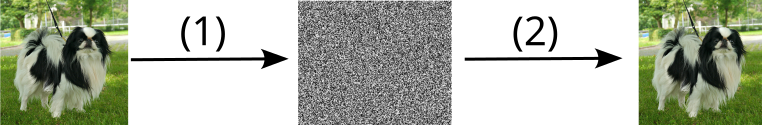    
    

Since sampling white noise is easy on a computer, if we can learn the transformation (2), we can sample from $\mu_\text{data}$, by first sampling white noise and then applying the learned transformation (2).

### Import of libraries and implementation of some plotting helpers (skip this)

In [18]:
import jax.numpy as jnp
import jax
from jax.experimental.host_callback import id_print
import matplotlib.pyplot as plt
from jax.lax import scan
from jax import grad, jit, vmap
import jax.random as random
from functools import partial
import numpy as onp
rng = random.PRNGKey(2022)
import flax.linen as nn
import optax


import scipy

import seaborn as sns
sns.set_style("darkgrid")
cm = sns.color_palette("mako_r", as_cmap=True)

def heatmap_data(positions, area_min=-2, area_max=2):
    
    def small_kernel(z, area_min, area_max):
        a = jnp.linspace(area_min, area_max, 512)
        x, y = jnp.meshgrid(a, a)
        dist = (x - z[0])**2 + (y - z[1])**2
        hm = jnp.exp(-350*dist)
        return hm

    #again we try to jit most of the code, but use the helper functions
    #since we cannot jit all of it because of the plt functions
    @jit
    def produce_heatmap(positions, area_min, area_max):
        return jnp.sum(vmap(small_kernel, in_axes=(0, None, None))(positions, area_min, area_max), axis=0)

    hm = produce_heatmap(positions, area_min, area_max) #np.sum(vmap(small_kernel)(to_plot), axis=0)
    return hm

def plot_heatmap(positions, area_min=-2, area_max=2):
    """
    positions: locations of all particles in R^2, array (J, 2)
    area_min: lowest x and y coordinate
    area_max: highest x and y coordinate
    
    will plot a heatmap of all particles in the area [area_min, area_max] x [area_min, area_max]
    """
    hm = heatmap_data(positions, area_min, area_max)
    extent = [area_min, area_max, area_max, area_min]
    im = plt.imshow(hm, cmap=cm, interpolation='nearest', extent=extent)
    ax = plt.gca()
    ax.invert_yaxis()
    return im

## Creating a toy dataset for training
To visualize our algorithm output, we will now create a toy dataset consisting of two disconnected spheres. We assume that we have 10 samples from each sphere, i.e. 20 training samples overall. These are in $R^2$. We then want to train the algorithm to generate more samples from the underlying distribution. 

Thinking of image datasets, each of the $20$ points would now represent one image and the two spheres would be the abstract distribution of all images. 



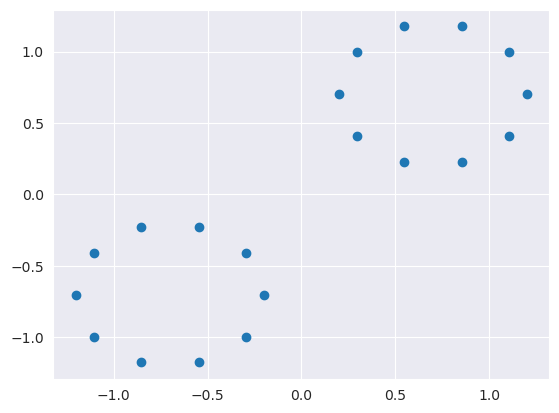

In [2]:
def sample_sphere(J):
    alphas = jnp.linspace(0, 2*jnp.pi * (1 - 1/J), J)
    xs = jnp.cos(alphas)
    ys = jnp.sin(alphas)
    mf = jnp.stack([xs, ys], axis=1)
    return mf

J = 20
sphere1 = sample_sphere(J//2) * 0.5 + 0.7
sphere2 = sample_sphere(J//2) * 0.5 - 0.7 
mf = jnp.concatenate((sphere1, sphere2))
plt.scatter(mf[:, 0], mf[:, 1]);

# First Try: How could we try to achieve the noising and denoising?
The most intuitive idea to achieve our goal is the following. We just take our training dataset, add lots of noise to it (this would be transformation (1)), and then train the neural network to predict the original datapoint again (transformation (2)). We now will try to do so

## We use a simple, fully connected Neural Network
This is one of the most straightforward neural networks there is. We just apply linear functions to the input and then interleave these linear functions with nonlinear activation functions. The specific choice of the nonlinear activation function is up to the user. We use `relu`, which is one of the most popular ones.

In [3]:
class FullyConnected(nn.Module):

    @nn.compact
    def __call__(self, x):
        in_size = x.shape[1]
        n_hidden = 256
        act = nn.relu
        x = nn.Dense(n_hidden)(x)
        x = act(x)
        x = nn.Dense(n_hidden)(x)
        x = act(x)
        x = nn.Dense(n_hidden)(x)
        x = act(x)
        x = nn.Dense(in_size)(x)
        return x
    
    

#some dummy input data. Flax is able to infer all the dimensions of the weights
#if we supply if with the kind of input data it has to expect
x = jnp.zeros(20).reshape((10, 2))
#initialize the model weights
denoiser = FullyConnected()
rng, srng = random.split(rng)
params = denoiser.init(srng, x)

#Initialize the optimizer
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

## Define the loss and update Function
The loss is as described above. We take some input `data`, and add standard normal noise.
However, optimally, we want there to be nearly no signal left in the noisy version: The neural network should learn to predict the original data from nearly white noise. Therefore, we also multiply the image with a small scalar (`0.01` in our case). Also, we predict the noise used to corrupt the data, instead of the data itself. Since the data can be recovered using the noisy version and subtracting the noise, this is equivalent. One can also directly predict the data, and some algorithms do so. 


The update function then takes the gradient of the loss function and applies it to the parameters of the neural network. Except for some improvements that the `adam` optimizer does (which we use), this is very close to just doing normal gradient descent.




In [4]:
def loss_fn(params, model, rng, data):
    #Noise the Data
    rng, step_rng = random.split(rng)
    noise = random.normal(step_rng, data.shape)
    noised_data = 0.01 * data + noise
    
    #Predict the Noise from the output
    output = model.apply(params, noised_data)
    loss = jnp.mean((noise - output)**2)
    return loss

@partial(jit, static_argnums=[4])
def update_step(params, rng, batch, opt_state, model):
    val, grads = jax.value_and_grad(loss_fn)(params, model, rng, batch)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return val, params, opt_state

## Let's train!
Training is now basically running gradient descent with the above loss function.

In [5]:
N_epochs = 60_000
train_size = mf.shape[0]
losses = []
for k in range(N_epochs):
    rng, step_rng = random.split(rng)
    loss, params, opt_state = update_step(params, step_rng, mf, opt_state, denoiser)
    losses.append(loss)
    if (k+1) % 5_000 == 0:
        mean_loss = onp.mean(onp.array(losses))
        losses = []
        print("Epoch %d,\t Loss %f " % (k+1, mean_loss))

Epoch 5000,	 Loss 0.001488 
Epoch 10000,	 Loss 0.000397 
Epoch 15000,	 Loss 0.000264 
Epoch 20000,	 Loss 0.000229 
Epoch 25000,	 Loss 0.000192 
Epoch 30000,	 Loss 0.000178 
Epoch 35000,	 Loss 0.000158 
Epoch 40000,	 Loss 0.000162 
Epoch 45000,	 Loss 0.000140 
Epoch 50000,	 Loss 0.000145 
Epoch 55000,	 Loss 0.000141 
Epoch 60000,	 Loss 0.000133 


## Plot the results
We now sample standard normal noise and just apply our learned denoiser from above to that standard normal distribution. Afterwards, we plot a heatmap. Optimally, that should look similar to the training data above, generalizing to the two spheres.

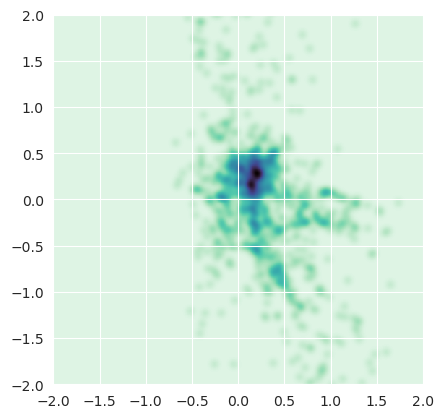

In [6]:
def sample(rng, N_samples, model, params):
    rng, step_rng = random.split(rng)
    noised_data = random.normal(step_rng, (N_samples, 2))
    predicted_noise = model.apply(params, noised_data)
    data = 100*(noised_data - predicted_noise)
    return data

N_samples = 1000
rng, srng = random.split(rng)
samples = sample(srng, N_samples, denoiser, params)
plot_heatmap(samples)

<h1 style="text-align: center;">That did not work</h1>
<h3 style="text-align: center;">What could we improve?</h3>
<p style="text-align: center;">The samples above depict a heatmap of 1000 samples that our neural network has generated. These look nothing like the two spheres from above - therefore we should try something else.</p>

```










































```

<h2 style="text-align:center;"> Add more denoising steps!</h2>

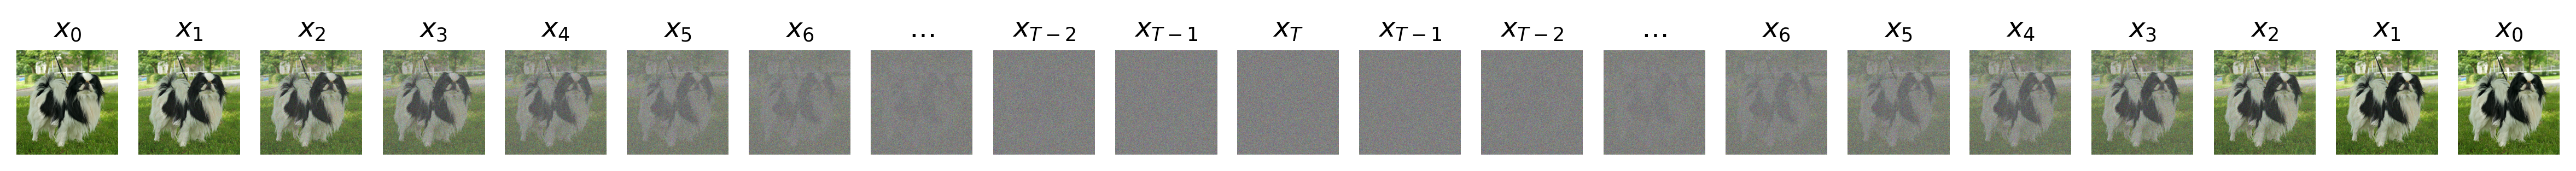

It seems that it is to hard for the neural network to learn to predict the true data from a very low signal and high noise version of it. But maybe we can **make the task simpler**. Instead of immediately going from noise to the image distribution, we can add intermediate steps. Then, the neural network only needs to be good enough to **predict a slightly less noisy version** from the current version. 

We call our original data $x_0$ and create more and more noisy versions $x_1, x_2, \ldots, x_T$ from it by iterating
$$
    x_{t+1} = \sqrt{1 - \beta_t}~x_t + \sqrt{\beta_t}~\xi_t, \qquad\qquad \text{with} \quad \xi_t \sim \mathcal{N}(0, I)
$$
for some small **noising speed** $\beta_t$. 

### Predicting $x_{t-1}$ from $x_t$ does not work
The most straightforward idea to implement the above would be to **learn an estimator** $\hat{\xi}_t$
$$
    \hat{\xi}_t \approx \xi_t
$$
of $\xi_t$ and then go back in time via
$$
    x_t \approx \frac{1}{\sqrt{1 - \beta_t}}(x_{t+1} - \sqrt{\beta_t}~\hat{\xi}_t).
$$
Learning the estimator is tractable: We can sample $x_0$ from the dataset and use the forward-noising scheme to get samples from $x_t$ and $x_{t+1}$. Then we would learn to predict $x_t$ from $x_{t+1}$.

However, this does not work in practice, at least not for me! I reckon that this is due to the fact that $x_t$ and $x_{t+1}$ are very similar to each other and it is a hard task for the neural network to learn what exactly it should be doing. However,, if someone has some better input on this, please feel free to get in touch!

### Predicting $x_0$ from $x_t$ but only using that information partially, works!
Since the formula for deriving $x_t$ from $x_{t-1}$ is so simple, we can apply it recursively and get a nice expression for $x_t$ in terms of $x_0$. It turns out, that we can write $x_t$ as
$$
    x_{t+1} = \sqrt{\alpha_t}~x_0 + \sqrt{1 - \alpha_t}~Z_t, \qquad\qquad \text{with} \quad Z_t \sim \mathcal{N}(0, I)
$$
with
$$
\alpha_i = \prod_{j=1}^i (1 - \beta_j).
$$
The $\alpha_t$ can be interpreted as the amount of signal left in $x_t$.

Now, we can try to again predict $Z_t$ from $x_t$. 

Note, that we are now back to our original setting. We want to learn the true image from noisy versions of it. However, we will now not only do this one time. For the largest value of $T$, the neural network will have nearly the same task as above: Predict $x_0$ from nearly white noise -- and we have seen that it will not do very well on that task. Therefore, after we use this first prediction of $x_0$, we will now use it to get a prediction of $x_{T-1}$ (a slightly less noisy version of $x_0$) by adding noise again. Therefore, we only use this bad first guess to move from $x_T$ to $x_{T-1}$ instead of directly using it as our estimate of $x_0$.
Then, we use another denoiser which is trained at level $T-1$ (in practice this will be the same neural network, but it has a time input to differentiate between the different noise levels) to get another guess of $x_0$. This guess is then used to move to the noise level $x_{T-2}$ and so on.

The full algorithm then looks like:

1. Predict the noise $\hat{Z}_t$ from $x_t$
2. Use that noise estimate to predict $\hat{x}_0 = \frac{1}{\sqrt{\alpha_t}}~(x_t - \sqrt{1- \alpha_t}~\hat{Z}_t)$.
3. Go back to a higher signal level $\alpha_{t-1}$ through $x_{t-1} = \sqrt{\alpha_{t-1}}~x_0 + \sqrt{1 - \alpha_{t-1}}~Z_{t-1}$

We iterate the above until we reach $t=0$.



### Timescales
The choice of $\beta_t$ is up to the person implementing the algorithm. One should make sure that the maximum $\alpha_T$ however is small enough, so that $x_T$ is close to white noise (because it will be nearly equal to $Z_T$). It is common to choose $\beta_t$ small for small $t$ and larger later one. Intuitively, that is because for large $t$, the denoising task is easier, since both $x_t$ and $x_{t+1}$ are close to Gaussian. Therefore, one can take larger steps.

The following is one of the more popular choices for $\beta_t$ (and therefore $\alpha_t$). It works by linearly interpolating $\beta_t$ from $0.1$ to $20$.

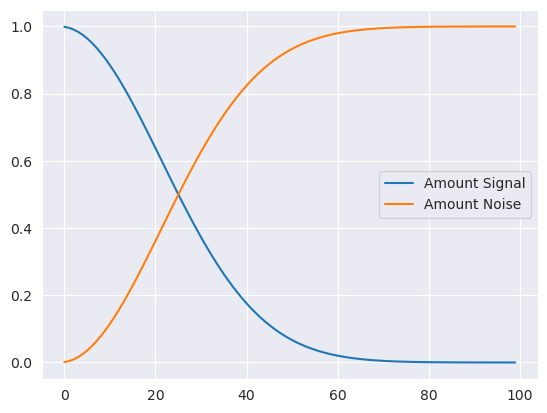

In [7]:
beta_min = 0.1
beta_max = 20

def get_alphas_betas(N):
    # We interpolate between taking small noising steps first (of size beta_min/N)
    # and taking larger steps at the end (of magnitude beta_max/N)
    # one can use any kind of beta scheduling here, and finding the best one is an open research question
    # The one we take is inspired by the scheduling chosen inhttps://github.com/yang-song/score_sde and 
    # has proven itself in practice
    
    betas = jnp.array([beta_min/N + i/(N*(N-1))*(beta_max-beta_min) for i in range(N)])
    # Note that N should be at least of the size beta_max so that all betas are positive
    
    alphas = jnp.cumprod(1 - betas)
    return alphas, betas

alphas, betas = get_alphas_betas(100)
plt.plot(alphas, label="Amount Signal")
plt.plot(1 - alphas, label="Amount Noise")
plt.legend()

### New Loss function that optimizes at a randomly chosen timescale
The loss function looks nearly as before, just that we now also sample random noise levels $\alpha$ to corrupt the data. The model now also takes the signal ration $\alpha$ as an input so that it can learn different denoisers for different levels.



In [8]:
def loss_fn(params, model, rng, data, alphas):
    rng, step_rng = random.split(rng)
    alpha = random.choice(step_rng, alphas, (data.shape[0],1))
    
    rng, step_rng = random.split(rng)
    noise = random.normal(step_rng, data.shape)

    
    noised_data = data * alpha**0.5 + noise * (1 - alpha)**0.5

    output = model.apply(params, noised_data, alpha)
    loss = jnp.mean((noise - output)**2)
    
    return loss


@partial(jit, static_argnums=[4])
def update_step(params, rng, batch, opt_state, model, alphas):
    val, grads = jax.value_and_grad(loss_fn)(params, model, rng, batch, alphas)
    # jax.debug.print("grads: {x}", x=jax.tree_map(lambda a: jnp.mean(a), grads))
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return val, params, opt_state

### New Neural network which also takes the noise level as an input
We now supply the neural network with a signal level input $t$. Therefore, it can distinguish between the different noise scales.
This name already suggests that we will can also interpret this parameter as time.

The network is still a linear feedforward network. All that we do is transform the time into so-called Fourier-features. They do not actually change the task, since they do not give the function new information (they are just transformations of $t$). Intuitively, one needs this step to show the neural network the importance of $t$ and make it easier for the NN to distinguish between different values of $t$, since the prediction/denoising task can be very different depending on the noise-scale/time parameter $t$.

In [9]:
import flax.linen as nn

class FullyConnectedWithTime(nn.Module):
    """A simple model with multiple fully connected layers and some fourier features for the time variable."""

    @nn.compact
    def __call__(self, x, t):
        in_size = x.shape[1]
        n_hidden = 256
        act = nn.relu
        t = jnp.concatenate([t - 0.5, jnp.cos(2*jnp.pi*t), jnp.sin(2*jnp.pi*t), -jnp.cos(4*jnp.pi*t)],axis=1)
        x = jnp.concatenate([x, t],axis=1)
        x = nn.Dense(n_hidden)(x)
        x = act(x)
        x = nn.Dense(n_hidden)(x)
        x = act(x)
        x = nn.Dense(n_hidden)(x)
        x = act(x)
        x = nn.Dense(in_size)(x)
        return x
    
x = jnp.zeros(2*10).reshape((10, 2))
time = jnp.ones((10, 1))
#initialize the model weights
denoiser_multiple_steps = FullyConnectedWithTime()
rng, srng = random.split(rng)
params_multiple_steps = denoiser_multiple_steps.init(srng, x, time)

#Initialize the optimizer
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params_multiple_steps)

### Training looks as before

In [10]:
train_size = mf.shape[0]
losses = []
for k in range(N_epochs):
    rng, step_rng = random.split(rng)
    loss, params_multiple_steps, opt_state = update_step(params_multiple_steps, step_rng, mf, opt_state, denoiser_multiple_steps, alphas)
    losses.append(loss)
    if (k+1) % 5_000 == 0:
        mean_loss = onp.mean(onp.array(losses))
        print("Epoch %d,\t Loss %f " % (k+1, mean_loss))
        losses = []

Epoch 5000,	 Loss 0.196400 
Epoch 10000,	 Loss 0.181512 
Epoch 15000,	 Loss 0.176624 
Epoch 20000,	 Loss 0.171174 
Epoch 25000,	 Loss 0.170849 
Epoch 30000,	 Loss 0.169433 
Epoch 35000,	 Loss 0.170603 
Epoch 40000,	 Loss 0.167742 
Epoch 45000,	 Loss 0.169246 
Epoch 50000,	 Loss 0.170066 
Epoch 55000,	 Loss 0.167391 
Epoch 60000,	 Loss 0.167233 


## Sampling looks different
During the sampling, we will now at each step make a new guess of $x_0$, the `denoised_guess`. Then, we will noise that denoised_guess again, but with the signal-level $\alpha_{t-1}$ to get an estimate of $x_t$. 

In the last step, we will not noise the signal again, but instead output our final guess of $x_0$.

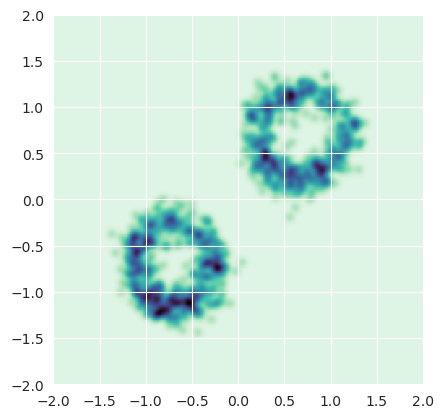

In [11]:
def sample_with_time(rng, N_samples, model, params, alphas, betas):
    rng, step_rng = random.split(rng)
    noised_data = random.normal(step_rng, (N_samples, 2))
    for i in range(len(betas)):
        beta = betas[-i]
        alpha = alphas[-i] * jnp.ones((noised_data.shape[0], 1))
        noise_guess = model.apply(params, noised_data, alpha)
        rng, step_rng = random.split(rng)
        denoised_guess = 1/alpha**0.5 * (noised_data - noise_guess*(1-alpha)**0.5)

        if i < len(betas)-1:
            new_noise = random.normal(step_rng, noised_data.shape)
            alpha_tm1 = alpha[-i-1]
            new_noised = denoised_guess * alpha_tm1**0.5 + (1-alpha)**0.5 * new_noise
            noised_data = new_noised
    
    return noised_data



rng, srng = random.split(rng)
samples = sample_with_time(srng, N_samples, denoiser_multiple_steps, params_multiple_steps, alphas, betas)
plot_heatmap(samples)

## This seems to work! We are getting two spheres
Above we again plot a heatmap of 1000 generated samples. And all of the samples are around the two spheres. Therefore, the neural network was able to learn the distribution. However, optimally, we would like the spheres to be less "smeared out". 

## Improving the above by not going to $x_0$ in between
As discussed above, it did not work learn to predict $x_{t-1}$ from $x_t$. 
Therefore, we learned to predict $x_0$, went to $x_0$ and then back to $x_{t-1}$.
However, it turns out, one can also use the guess of $x_0$ to directly go from $x_t$ to $x_{t-1}$ without going to $x_0$ in between. We do this by still employing our guess of $x_0$ given $x_t$, but only moving in that direction a little bit:

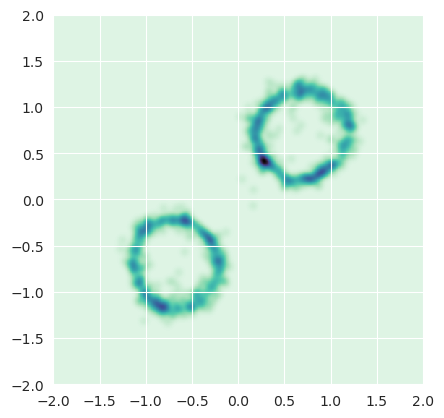

In [12]:
def sample_with_time(rng, N_samples, model, params, alphas, betas):
    rng, step_rng = random.split(rng)
    all_outputs = onp.zeros((len(betas)+1, N_samples, 2))
    noised_data = random.normal(step_rng, (N_samples, 2))
    all_outputs[0, :, :] = noised_data
    for i in range(len(betas)):
        beta = betas[-i]
        alpha = alphas[-i] * jnp.ones((noised_data.shape[0], 1))
        noise_guess = model.apply(params, noised_data, alpha)
        rng, step_rng = random.split(rng)
        new_noise = random.normal(step_rng, noised_data.shape)
        noised_data = 1/(1 - beta)**0.5 * (noised_data - beta/(1 - alpha)**0.5 * noise_guess)
        if i < len(betas)-1:
            noised_data += beta**0.5 * new_noise

        all_outputs[i+1, :, :] = noised_data
        
    return noised_data, all_outputs



rng, srng = random.split(rng)
samples, all_outputs = sample_with_time(srng, N_samples, denoiser_multiple_steps, params_multiple_steps, alphas, betas)
im = plot_heatmap(samples)

## This works nicely!
This works extremely well, and is actually one of the diffusion model implementations used in practice! The way how we go from $x_t$ to $x_{t-1}$ is the way introduced in [1] and [2] (see references at the bottom of the notebook), while the noising scheme is the one employed in [3]. The works [1], [2] and [3] are 3 of the most influential works on this topic. 

After these works have been released, there have studying tweaks to the above algorithm to improve the performance even further has been a very active field of research, see for example [4] or [5]. Nevertheless, if one exchanges the neural network for a more sophisticated architecture (normally UNets), the above implementation can already be used to sample image distributions!

### Animation of diffusion flow
We now animate how the distribution evolves through time. At the beginning, we see scattered particles, which are from a normal distribution. As the time evolves, they mix around, all the particles converge to the two spheres. These final particles are then output as samples by the algorithm.



In [17]:
import matplotlib.animation as animation
fig = plt.figure( figsize=(8,8))
im = plot_heatmap(samples)

def animate(frame):
    im.set_array(heatmap_data(all_outputs[frame, :, :]))
    return [im]

anim = animation.FuncAnimation(fig, animate, frames=all_outputs.shape[0])
anim.save('samples.mp4', fps=10, extra_args=['-vcodec', 'libx264'])
from IPython.display import Video
Video("samples.mp4")

# Continuous-Time limit
In the above, we are taking small steps to move from $x_t$ to a similar $x_{t-1}$. It turns out, that if we let the step size go to zero, this will limit into a stochastic differential equation (SDE) (see [3]), and one can formulate the whole algorithm as a discretization of a SDE!

Furthermore, in the continuous-time limit, many of the resulting objects are actually well known (the denoiser approximates gradients of potentials and implements a time reversal of the SDE). The two formulations of diffusion models are mostly equivalent, and everyone can choose the one that they like. In the continuous time limit one can also derive an ordinary differential equation for the denoiser, connecting diffusion models to normalizing flows. Furthermore, there are connections to optimal control and smoothing, to drop some more buzz words!

If you are interested in an introduction to the continuous-time diffusion models, also called score-based generative models, there is another notebook at [http://jakiw.com/sgm_intro](jakiw.com/sgm_intro) which delves into that topic. It also studies generalization/overfitting properties of diffusion models.



# References
**Placement of the following works:** The works [1]-[4] are some of the most influential works on diffusion models that have been published. The works [1] and [2] use the discrete-time formulation of diffusion models at which we arrive at the end (without going to $x_0$ in between). However, they derive it differently to how we did it here (through minimizing KL/ELBO). Going to $x_0$ in between has for example been explored in the following work [6], where arbitrary (not Gaussian, but for example just blurring out) corruptions of $x_0$ were studied. In the work [4] it was empirically shown that diffusion models can beat GANs, which were the state-of-the-art model before. 

[1] Deep Unsupervised Learning using Nonequilibrium Thermodynamics by Jascha Sohl-Dickstein, Eric A. Weiss, Niru Maheswaranathan, Surya Ganguli (https://arxiv.org/abs/1503.03585)

[2] Denoising Diffusion Probabilistic Models, Jonathan Ho, Ajay Jain, Pieter Abbeel (https://arxiv.org/abs/2006.11239)

[3] Score-Based Generative Modeling through Stochastic Differential Equations by Yang Song, Jascha Sohl-Dickstein, Diederik P. Kingma, Abhishek Kumar, Stefano Ermon, Ben Poole (https://arxiv.org/abs/2011.13456)

[4] Diffusion Models Beat GANs on Image Synthesis, Prafulla Dhariwal, Alex Nichol (https://arxiv.org/abs/2105.05233)

[5] Elucidating the Design Space of Diffusion-Based Generative Models, Tero Karras, Miika Aittala, Timo Aila, Samuli Laine (https://arxiv.org/abs/2206.00364)

[6] Cold Diffusion: Inverting Arbitrary Image Transforms Without Noise by Arpit Bansal, Eitan Borgnia, Hong-Min Chu, Jie S. Li, Hamid Kazemi, Furong Huang, Micah Goldblum, Jonas Geiping, Tom Goldstein (https://arxiv.org/abs/2208.09392)

